In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import os
import statsmodels.api as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


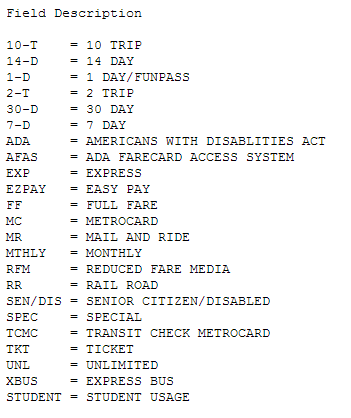

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

In [3]:
#bash commands run to move data cube file for reproducability
#!curl -O https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW10_fb55/MTA_Fare.npy
#!mv 'MTA_Fare.npy' $PUIDATA  

In [4]:
mtaRides = np.load(os.getenv("PUIDATA") + "/MTA_Fare.npy")
mtaRides.shape
# axis 0 = 600, number of stations
# axis 1 = 23, card types
# axis 2 = 194, number of weeks, from 05/21/2010 to 02/21/2014

(600, 23, 194)

###### There are 196 weeks between the provided dates of 05/21/2010 to 02/21/2014, but only 194 datapoints along the axis. The analysis below in Part 1 points to Hurricane Sandy as the most prominent event, so the start date will be shifted by 1 week to align the date range and match the analysis.

In [5]:
# create date range
# adjusted started date to 5/28/2010 to match analysis below
dates = pd.date_range(start='05/28/2010', periods=194, freq='W').date 

In [6]:
# convert all negative values to nan
mtaRides = mtaRides.astype(float)
mtaRides[mtaRides<0] = np.nan

In [7]:
stations = np.nansum(mtaRides, axis=1)
print (stations.shape)

(600, 194)


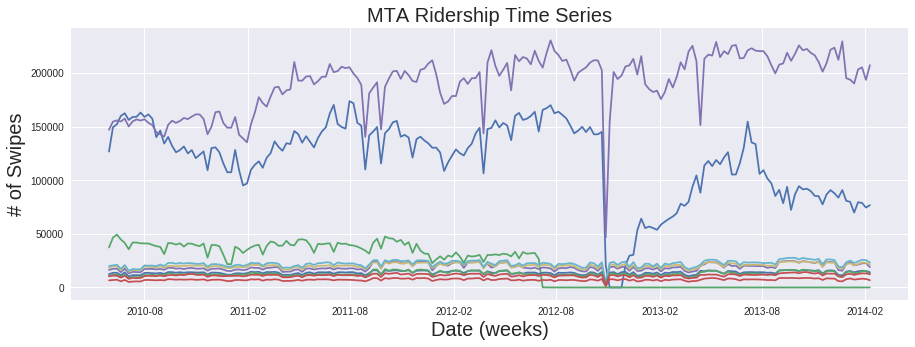

In [8]:
plt.figure(figsize = (15,5))
for i in range(0,10): # only plotting first few, for visualization
    plt.plot(dates, stations[i])
plt.xlabel("Date (weeks)", fontsize=20)
plt.ylabel("# of Swipes", fontsize=20)
plt.title("MTA Ridership Time Series", fontsize=20);

#### Figure 1. This shows a sampling of time series for MTA ridership in several stations. Only 10 out of 600 available stations have been plotted here, and serves to help visualize the data.

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [9]:
mta_allsum = np.nansum(mtaRides, axis=1)
print (mta_allsum.shape)

(600, 194)


In [10]:
mta_allsum = np.nansum(mta_allsum, axis=0)
print (mta_allsum.shape)

(194,)


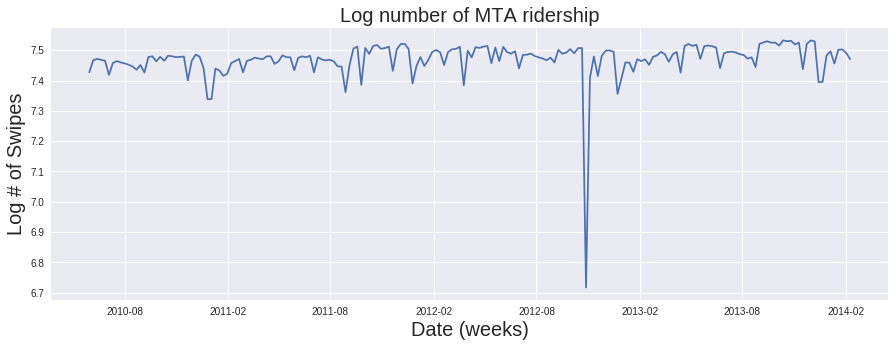

In [11]:
plt.figure(figsize = (15,5))
plt.plot(dates, np.log10(mta_allsum))
plt.xlabel("Date (weeks)", fontsize=20)
plt.ylabel("Log # of Swipes", fontsize=20)
plt.title("Log number of MTA ridership", fontsize=20);

#### Figure 2. This shows the log number of swipes for total MTA ridership in the 600 Manhattan stations vs time.

In [12]:
mta_avgRides = np.nanmean(mta_allsum)
mta_stdRides = np.nanstd(mta_allsum)
print ("mean rides by week {:.2f}".format(mta_avgRides))
print ("stdev rides by week {:.2f}".format(mta_stdRides))

mean rides by week 29781349.87
stdev rides by week 2983960.42


In [13]:
thresholds = [mta_avgRides  + 3 * mta_stdRides, 
              mta_avgRides  - 3 * mta_stdRides]
print ("3-sigma thresholds {:.2f}, {:.2f}".format(*thresholds))

3-sigma thresholds 38733231.14, 20829468.61


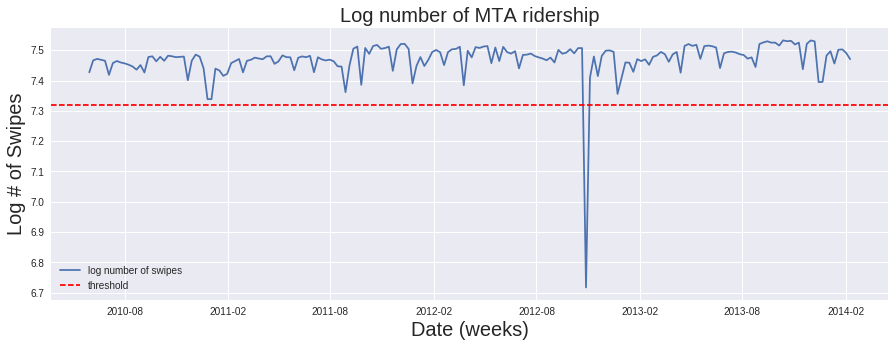

In [14]:
plt.figure(figsize = (15,5))
ax = plt.plot(dates, np.log10(mta_allsum), label = 'log number of swipes');
plt.axhline(y=np.log10(thresholds[1]), color='r', linestyle='--', label = 'threshold')
plt.xlabel("Date (weeks)", fontsize=20)
plt.ylabel("Log # of Swipes", fontsize=20)
plt.title("Log number of MTA ridership", fontsize=20)
plt.legend();

#### Figure 3. This is the same as Figure 2, but with an additional line showing the 3-sigma threshold for event detection. The sharp drop in ridership appears to fall in the fall/winter of 2012.

In [15]:
event = dates[np.where(mta_allsum<thresholds[1])]
print(event)

[datetime.date(2012, 10, 28)]


### The event leading to the drop in rides on the week of 10/28/2012 corresponds to Hurricane Sandy.



## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


In [16]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [17]:
mta_timeavg = np.nanmean(mtaRides, axis=0)
print (mta_timeavg.shape)

(23, 194)


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [18]:
df = pd.DataFrame(mta_timeavg).T
df.columns = list(ridetype)
df.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,24880.119048,1148.320346,103.465368,403.790043,101.316017,8003.123377,18510.686147,21.781385,721.205628,1108.294372,...,266.523810,1710.194805,129.456710,61.084416,0.00000,269.898268,45.584416,13.264069,0.774892,NaN
1,27173.229935,1265.798265,111.683297,432.167028,139.594360,8637.327549,20577.861171,25.698482,613.351410,1253.845987,...,329.605206,1969.778742,150.127983,70.136659,0.00000,264.019523,47.006508,13.275488,1.028200,NaN
2,27573.708423,1266.077754,111.524838,431.248380,123.097192,8710.647948,20467.684665,26.516199,652.328294,1329.453564,...,327.295896,1974.349892,150.267819,70.449244,0.00000,263.889849,46.291577,14.017279,1.004320,NaN
3,27329.751620,1215.123110,112.447084,424.166307,80.840173,8710.049676,20410.542117,24.235421,659.855292,1309.438445,...,317.697624,1949.349892,147.082073,69.987041,0.00000,263.609071,46.717063,14.233261,1.045356,NaN
4,27607.099138,1182.883621,110.243534,420.006466,75.883621,8460.012931,20030.176724,22.661638,723.663793,1214.323276,...,297.172414,1843.907328,143.053879,68.821121,0.37931,258.137931,43.743534,13.605603,0.974138,NaN


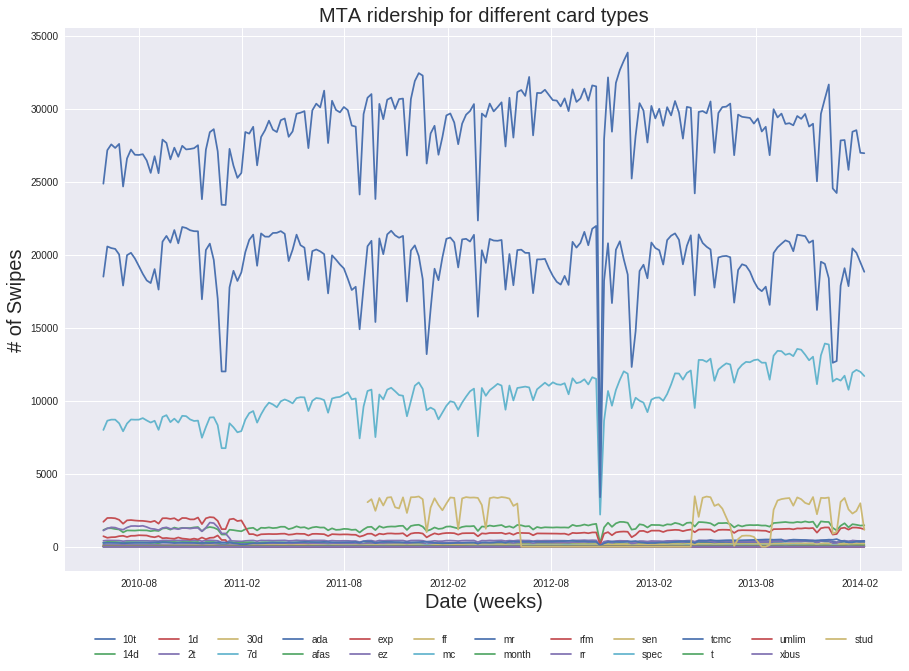

In [19]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

for card in ridetype:
    ax.plot(dates, df[card], label=card)
    ax.legend(ridetype, loc=9, bbox_to_anchor=(0.5, -0.1), ncol=12)
plt.xlabel("Date (weeks)", fontsize=20)
plt.ylabel("# of Swipes", fontsize=20)
plt.title("MTA ridership for different card types", fontsize=20);

#### Figure 4. This figure shows the number of swipes across all 600 stations for different Metrocard types. Each time series corresponds to a different card type.

In [20]:
mtaAvg_rmean = pd.DataFrame()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


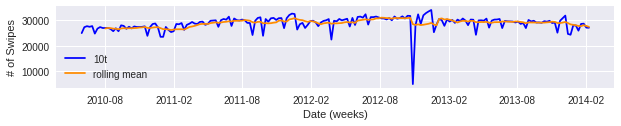

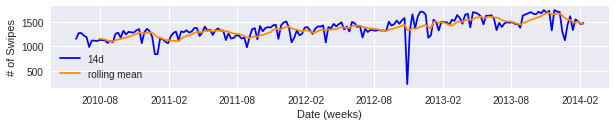

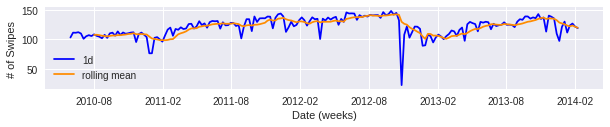

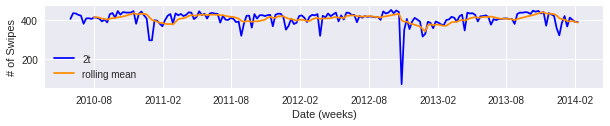

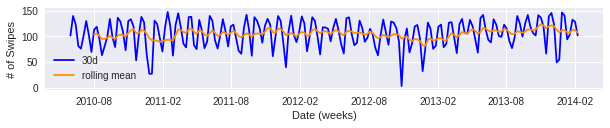

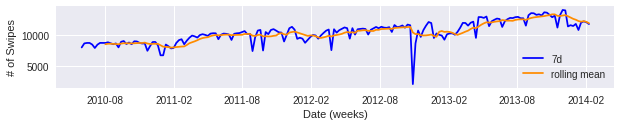

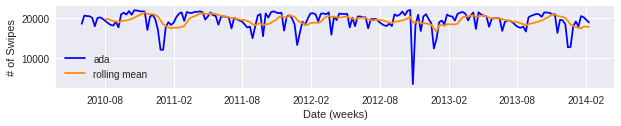

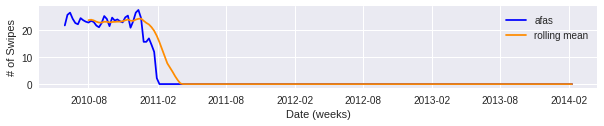

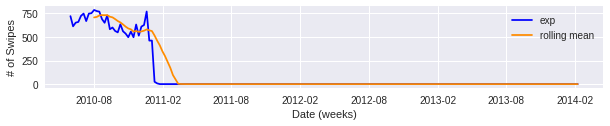

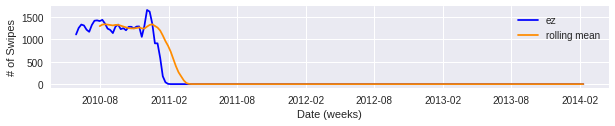

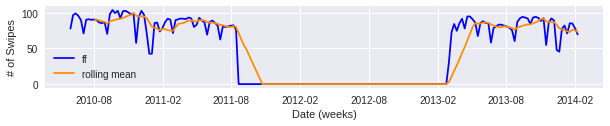

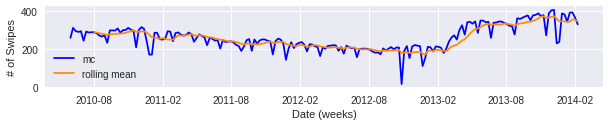

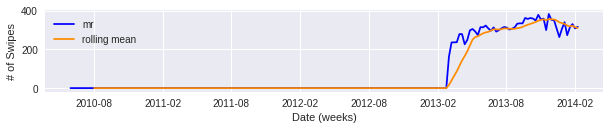

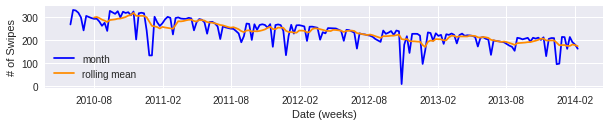

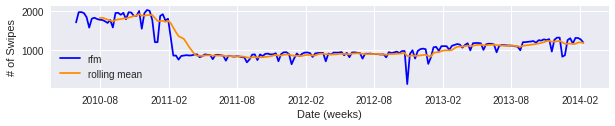

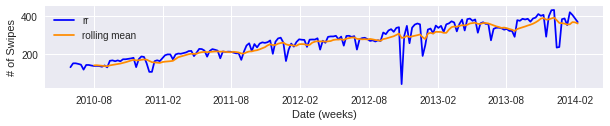

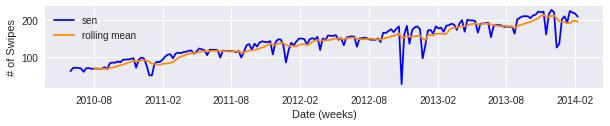

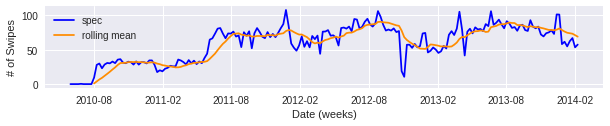

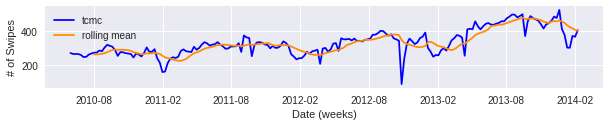

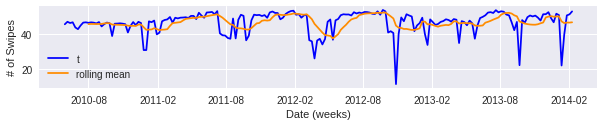

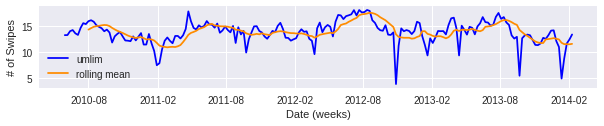

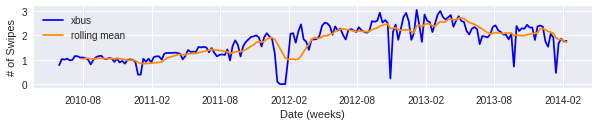

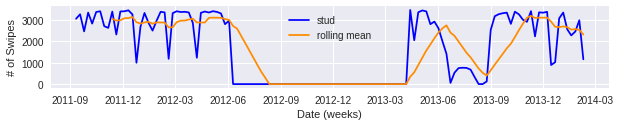

In [21]:
for card in ridetype:
    fig = plt.figure(figsize=(10,1.5))
    ax = fig.add_subplot(111)
    mtaAvg_rmean[card] = pd.rolling_mean((df[card]), 10)
    ax.legend(card)
    ax.plot(dates, df[card], label=card, c='blue')
    ax.plot(dates, mtaAvg_rmean[card], label='rolling mean', c='darkorange')
    ax.legend()
    plt.xlabel("Date (weeks)")
    plt.ylabel("# of Swipes")

#### Figure 5. This figure separates the 23 time series onto different axes, and shows both the raw ridership as well as the smoothed rolling mean.

In [22]:
# calculating ratio between first 10 and last 10 
rmean_dict = {}
for card in ridetype:
    first_ind = mtaAvg_rmean[card].first_valid_index()
    first_ind_range = range(first_ind,first_ind+10)
    
    last_ind = mtaAvg_rmean[card].last_valid_index()
    last_ind_range = range(last_ind-10, last_ind)
    
    first10Avg = mtaAvg_rmean[card].iloc[first_ind_range].mean()
    last10Avg = mtaAvg_rmean[card].iloc[last_ind_range].mean()
    
    rmean_dict[card] = last10Avg/first10Avg

In [23]:
for key, value in sorted(rmean_dict.iteritems(), key=lambda (k,v): (v,k)):
    print "%s: %.2f" % (key, value)

ez: 0.00
exp: 0.00
afas: 0.00
month: 0.63
rfm: 0.66
umlim: 0.82
ff: 0.89
stud: 0.92
ada: 0.95
2t: 0.99
10t: 1.06
t: 1.06
30d: 1.13
1d: 1.20
mc: 1.26
14d: 1.37
7d: 1.46
tcmc: 1.60
xbus: 1.96
rr: 2.65
sen: 2.87
spec: 5.51
mr: 32298.97


We can use the AD Fuller test to test for stationarity to check the visual inspection. The null hypothesis is that the time series has a unit root, meaning it is non-stationary. Significance value of 0.05.

In [24]:
print("Stationary series:")
for card in ridetype:
    pVal = sm.tsa.adfuller(np.array(mtaAvg_rmean[card].dropna()))[1]
    if pVal <=0.05:
        print("%s, p-value: %.3f" %(card, pVal))

Stationary series:
ada, p-value: 0.002
afas, p-value: 0.000
exp, p-value: 0.004
ez, p-value: 0.001
rfm, p-value: 0.015
t, p-value: 0.000
umlim, p-value: 0.023


Those cards are had p-values less than 0.05 so we can reject the null hypothesis and assume that those time series are stationary. Let's drop from our dictionary for clarity.

In [25]:
for i in ('ada','afas','exp','ez','rfm', 't', 'unlim'):
    rmean_dict.pop(i, None)

In [26]:
print("Start to End Ratios:")
for key, value in sorted(rmean_dict.iteritems(), key=lambda (k,v): (v,k)):
    print "%s: %.2f" % (key, value)

Start to End Ratios:
month: 0.63
umlim: 0.82
ff: 0.89
stud: 0.92
2t: 0.99
10t: 1.06
30d: 1.13
1d: 1.20
mc: 1.26
14d: 1.37
7d: 1.46
tcmc: 1.60
xbus: 1.96
rr: 2.65
sen: 2.87
spec: 5.51
mr: 32298.97


This seems to indicate that the card type with the steepest increase is 'mr' (Mail and Ride), while the card type with the steepest decrease is 'month' (Monthly).

However, with visual inspection of each the time series, we can see that some of those time series return high ratios because of their unusual structure - they don't have constant trends through the entire time series, or there are spikes/points of change. So those should be ignored and we should look at the card types with constant trends. Those card types are: ff, mr, stud, spec.

##### Thus, the card type with the steepest increase is 'sen' (Senior), and the card type with the steepest decrease is 'month' (Monthly).

In [27]:
print("Senior: ratio of %.2f" % rmean_dict['sen'])
print("Monthly: ratio of %.2f" % rmean_dict['month'])

Senior: ratio of 2.87
Monthly: ratio of 0.63


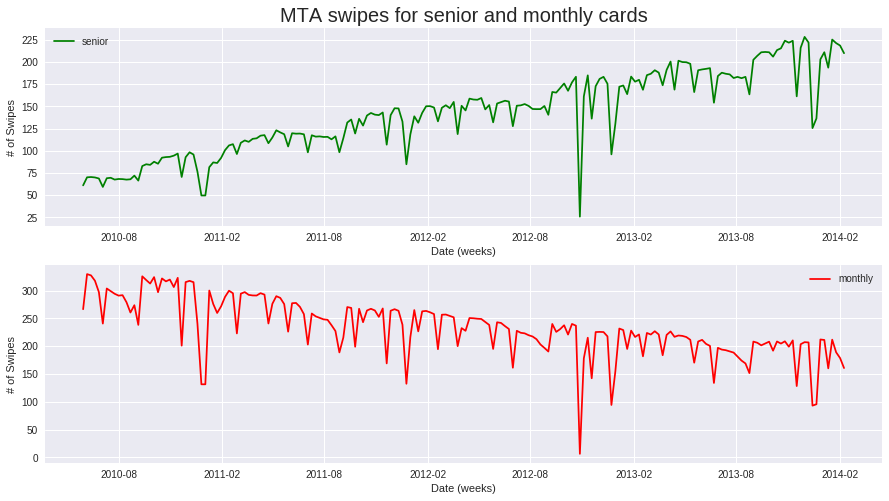

In [28]:
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(dates, df['sen'], label='senior', c='g')
ax2.plot(dates, df['month'], label='monthly', c='r')
ax1.legend()
ax2.legend()
ax1.set_xlabel("Date (weeks)")
ax1.set_ylabel("# of Swipes")
ax1.set_title('MTA swipes for senior and monthly cards', fontsize=20)
ax2.set_xlabel("Date (weeks)")
ax2.set_ylabel("# of Swipes");

#### Figure 6. This figure shows the two time series with the steepest increase (senior) and decrease (monthly). Both of these series have consistent trends over time.

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [29]:
stations = np.nansum(mtaRides, axis=1)
print (stations.shape)

(600, 194)


There are n=194 datapoints in each series


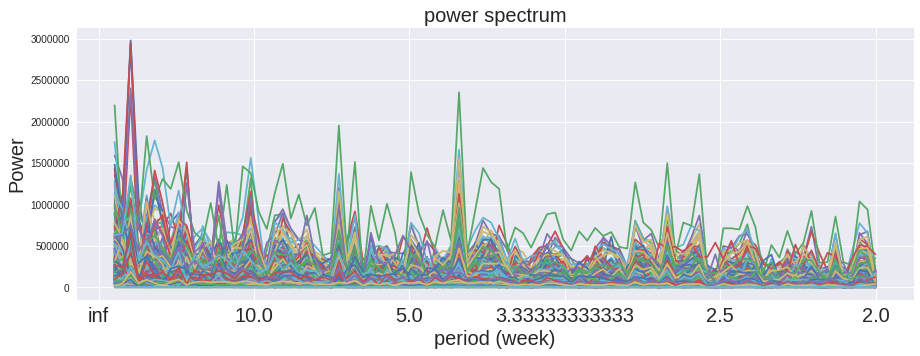

In [30]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
N = 194
print ("There are n=%d datapoints in each series"%N)

x = np.fft.rfftfreq(N, 1.0)

for i in range(len(stations)):
    f = np.abs(np.fft.rfft(stations[i]))
    plt.plot(x[2:], f[2:], '-')

#changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
plt.xlabel("period (week)", fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.title("power spectrum", fontsize=20);

#### Figure 7. This figure shows the power spectrums for ridership in each of the 600 stations. The sharp spikes indicate periodicity.

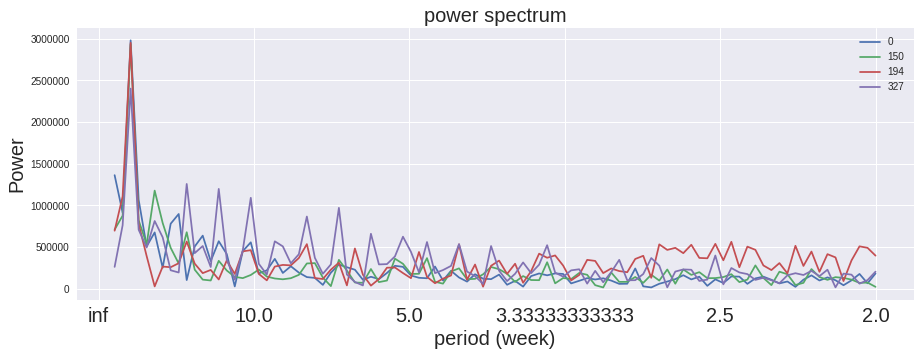

In [31]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(len(stations)):
    f = np.abs(np.fft.rfft(stations[i]))
    if f[2:].max() > 2400000: # arbitrary filter to obtain 4 stations with highest periodicity
        plt.plot(x[2:], f[2:], '-', label=i)
        plt.legend()
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
plt.xlabel("period (week)", fontsize=20)
plt.ylabel("Power", fontsize=20)
plt.title("power spectrum", fontsize=20);

#### Figure 8. This figure shows the power spectrums for the 4 stations that have the highest spikes in the power. This indicates that they have the most prominent periodicities.

#### The 4 stations with the most prominent annual periodicity are 0, 150, 194, and 327.

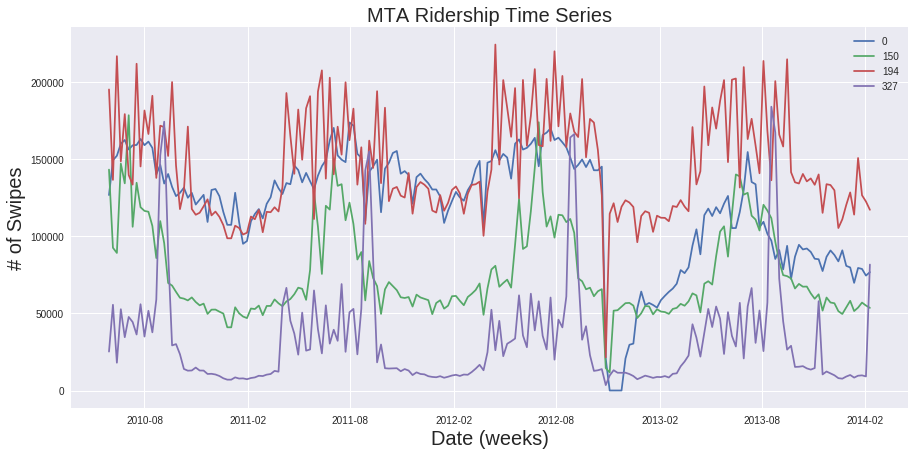

In [32]:
four_stations = [0,150,194,327]
plt.figure(figsize = (15,7))
for i in four_stations:
    plt.plot(dates, stations[i])
    plt.legend(four_stations)
plt.xlabel("Date (weeks)", fontsize=20)
plt.ylabel("# of Swipes", fontsize=20)
plt.title("MTA Ridership Time Series", fontsize=20);

#### Figure 9. This figure shows the ridership time series for the 4 stations determined to have the most prominent annual periodicities. 

#### By plotting the number of swipes for just these 4 stations, we can see that there is a very prounounced annual periodicity of greater activity in the warmer months (roughly April-September). It's likely that these 4 stations are strongly associated with parks or outdoor tourist attractions (Central Park, Battery Park, etc.) that have relatively low ridership in the cold months. 

#### Station #327 also appears to have an additional very sharp annual spike around the last week of August and first week of September. It's not entirely clear why there is this additional spike, but one possibility is that the station corresponds to the 9/11 museum & memorial - a combination of Labor Day weekend availability and the run-up to the 9/11 anniversary could be causing the jump.


## ASH Score 100. Extra Credit 0